In [1]:
import os
import dill as pickle
import pandas as pd
import pycmtensor as cmt
from pycmtensor import aet as aet
from pycmtensor.expressions import Beta, Weights
from pycmtensor.optimizers import Adam
from pycmtensor.results import Results
from pycmtensor.models import MNLogit
from reslogitlayer import ResLogitLayer

cmt.logger.set_level(cmt.logger.WARNING)
cmt.__version__

In [2]:
nb_path = os.path.abspath("")
df_rp = pd.read_csv("data/model_average_RP.csv")
df_rp.columns = df_rp.columns.str.upper()

df_rp["PURPOSE_WORK"] = 0
df_rp["PURPOSE_HOME"] = 0
df_rp["PURPOSE_LEISURE"] = 0
df_rp.loc[df_rp["PURPOSE"].str.split(" ", expand=True)[0] == "Work", "PURPOSE_WORK"] = 1
df_rp.loc[df_rp["PURPOSE"].str.split(" ", expand=True)[0] == "Home", "PURPOSE_HOME"] = 1
df_rp.loc[
    df_rp["PURPOSE"].isin(
        [
            "Cinema or other night out",
            "Clothes shopping",
            "Family Activity",
            "Leisure Other",
            "Museum/cultural",
            "Social",
            "Restaurant",
            "Sports activity",
            "Shopping - Major",
        ]
    ),
    "PURPOSE_LEISURE",
] = 1

df_rp["WEEKEND"] = 0
df_rp.loc[df_rp["DAY_OF_THE_WEEK_START"].isin(["Saturday", "Sunday"]), "WEEKEND"] = 1
df_rp.drop(["PURPOSE", "DAY_OF_THE_WEEK_START"], axis=1, inplace=True)
df_rp.fillna(0, inplace=True)

db = cmt.Database("model_average_rp", df_rp, choiceVar="CHOICE")
globals().update(db.variables)

# additional steps to format database
db.data["CHOICE"] -= 1
for i in [
    "TOTAL_CAR_COST",
    "BUS_COST_TOTAL_PER_LEG",
    "RAIL_COST_TOTAL_PER_LEG",
    "TAXI_COST",
]:
    db.data[i] /= 100.0

for i in [
    "CAR_DISTANCE_KM",
    "BUS_DISTANCE_KM",
    "RAIL_DISTANCE_KM",
    "TAXI_DISTANCE_KM",
    "CYCLING_DISTANCE_KM",
    "WALKING_DISTANCE_KM",
]:
    db.data[i] /= 100.0

for i in [
    "CAR_TRAVEL_TIME_MIN",
    "BUS_TRAVEL_TIME_MIN",
    "RAIL_TRAVEL_TIME_MIN",
    "TAXI_TRAVEL_TIME_MIN",
    "CYCLING_TRAVEL_TIME_MIN",
    "WALKING_TRAVEL_TIME_MIN",
    "BUS_IVT_TIME_MIN",
    "BUS_ACCESS_EGRESS_TIME_MIN",
    "RAIL_IVT_TIME_MIN",
    "RAIL_ACCESS_EGRESS_TIME_MIN",
]:
    db.data[i] /= 60.0

# specify Beta parameters
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
b_dist = Beta("b_dist", 0.0, None, None, 0)

b_IVT = Beta("b_IVT", 0.0, None, None, 0)
b_egress = Beta("b_egress", 0.0, None, None, 0)
b_transfers = Beta("b_transfers", 0.0, None, None, 0)

b_ncar = Beta("b_ncar", 0.0, None, None, 0)
b_nbicycle = Beta("b_nbicycle", 0.0, None, None, 0)

b_weekend_car = Beta("b_weekend_car", 0.0, None, None, 0)
b_weekend_pt = Beta("b_weekend_pt", 0.0, None, None, 0)
b_weekend_phys = Beta("b_weekend_phys", 0.0, None, None, 0)

b_cleeds_car = Beta("b_cleeds_car", 0.0, None, None, 0)
b_cleeds_pt = Beta("b_cleeds_pt", 0.0, None, None, 0)
b_cleeds_phys = Beta("b_cleeds_phys", 0.0, None, None, 0)

b_female_car = Beta("b_female_car", 0.0, None, None, 0)
b_female_pt = Beta("b_female_pt", 0.0, None, None, 0)
b_female_phys = Beta("b_female_phys", 0.0, None, None, 0)

b_age_car = Beta("b_age_car", 0.0, None, None, 0)
b_age_pt = Beta("b_age_pt", 0.0, None, None, 0)
b_age_phys = Beta("b_age_phys", 0.0, None, None, 0)

b_uk_car = Beta("b_uk_car", 0.0, None, None, 0)
b_uk_pt = Beta("b_uk_pt", 0.0, None, None, 0)
b_uk_phys = Beta("b_uk_phys", 0.0, None, None, 0)

b_edu_gba_car = Beta("b_edu_gba_car", 0.0, None, None, 0)
b_edu_gba_pt = Beta("b_edu_gba_pt", 0.0, None, None, 0)
b_edu_gba_phys = Beta("b_edu_gba_phys", 0.0, None, None, 0)

b_n_emp_car = Beta("b_n_emp_car", 0.0, None, None, 0)
b_n_emp_pt = Beta("b_n_emp_pt", 0.0, None, None, 0)
b_n_emp_phys = Beta("b_n_emp_phys", 0.0, None, None, 0)

b_mar_car = Beta("b_mar_car", 0.0, None, None, 0)
b_mar_pt = Beta("b_mar_pt", 0.0, None, None, 0)
b_mar_phys = Beta("b_mar_phys", 0.0, None, None, 0)

b_hhsize_car = Beta("b_hhsize_car", 0.0, None, None, 0)
b_hhsize_pt = Beta("b_hhsize_pt", 0.0, None, None, 0)
b_hhsize_phys = Beta("b_hhsize_phys", 0.0, None, None, 0)

b_ppinc_lt30k_car = Beta("b_ppinc_lt30k_car", 0.0, None, None, 0)
b_ppinc_lt30k_pt = Beta("b_ppinc_lt30k_pt", 0.0, None, None, 0)
b_ppinc_lt30k_phys = Beta("b_ppinc_lt30k_phys", 0.0, None, None, 0)

b_hhinc_lt50k_car = Beta("b_hhinc_lt50k_car", 0.0, None, None, 0)
b_hhinc_lt50k_pt = Beta("b_hhinc_lt50k_pt", 0.0, None, None, 0)
b_hhinc_lt50k_phys = Beta("b_hhinc_lt50k_phys", 0.0, None, None, 0)

b_ft_car = Beta("b_ft_car", 0.0, None, None, 0)
b_ft_pt = Beta("b_ft_pt", 0.0, None, None, 0)
b_ft_phys = Beta("b_ft_phys", 0.0, None, None, 0)

asc_car = Beta("asc_car", 0.0, None, None, 1)
asc_bus = Beta("asc_bus", 0.0, None, None, 0)
asc_rail = Beta("asc_rail", 0.0, None, None, 0)
asc_taxi = Beta("asc_taxi", 0.0, None, None, 0)
asc_cycling = Beta("asc_cycling", 0.0, None, None, 0)
asc_walking = Beta("asc_walking", 0.0, None, None, 0)

# 1: car, 2: bus, 3: rail, 4: taxi, 5: cycling, 6: walking.
# specify weight parameters
W1 = Weights("ResNet_01a", (6, 16), 0, True)
W2 = Weights("ResNet_01b", (16, 6), 0, True)

U_1 = (
    b_cost * db["TOTAL_CAR_COST"]
    + b_time * db["CAR_TRAVEL_TIME_MIN"]
    + b_dist * db["CAR_DISTANCE_KM"]
    + b_ncar * db["N_CAR"]
    + b_weekend_car * db["WEEKEND"]
    + b_cleeds_car * db["CITY.LEEDS"]
    + b_female_car * db["FEMALE"]
    + b_age_car * (db["AGE"] <= 3) # age < 30
    + b_uk_car * (db["BRITISH_ORIGIN"])
    # + b_edu_gba_car * ((db["MASTERS"] + db["PHD"]) > 0)
    + b_n_emp_car * db["NB_HH_EMPLOYED"]
    # + b_mar_car * aet.eq(db["MAR"], 2) # married
    + b_hhsize_car * db["HH_SIZE"]
    # + b_hhinc_lt50k_car * (db["INCOME_HH"] <= 5)
    # + b_ppinc_lt30k_car * (db["INCOME_PERSO"] <= 3)
    + b_ft_car * db["OCC_FULL_TIME"]
    + asc_car
)

U_2 = (
    b_cost * db["BUS_COST_TOTAL_PER_LEG"]
    + b_time * db["BUS_TRAVEL_TIME_MIN"]
    + b_dist * db["BUS_DISTANCE_KM"]
    + b_IVT * db["BUS_IVT_TIME_MIN"]
    + b_egress * db["BUS_ACCESS_EGRESS_TIME_MIN"]
    + b_transfers * db["BUS_TRANSFERS"]
    + b_weekend_pt * db["WEEKEND"]
    + b_cleeds_pt * db["CITY.LEEDS"]
    # + b_female_pt * db["FEMALE"]
    + b_age_pt * (db["AGE"] <= 3) # age < 30
    + b_uk_pt * (db["BRITISH_ORIGIN"])
    + b_edu_gba_pt * ((db["MASTERS"] + db["PHD"]) > 0)
    + b_n_emp_pt * db["NB_HH_EMPLOYED"]
    + b_mar_pt * aet.eq(db["MAR"], 2) # married
    + b_hhsize_pt * db["HH_SIZE"]
    + b_hhinc_lt50k_pt * (db["INCOME_HH"] <= 5)
    # + b_ppinc_lt30k_pt * (db["INCOME_PERSO"] <= 3)
    + b_ft_pt * db["OCC_FULL_TIME"]
    + asc_bus
)

U_3 = (
    b_cost * db["RAIL_COST_TOTAL_PER_LEG"]
    + b_time * db["CAR_TRAVEL_TIME_MIN"]
    + b_dist * db["RAIL_DISTANCE_KM"]
    + b_IVT * db["RAIL_IVT_TIME_MIN"]
    + b_egress * db["RAIL_ACCESS_EGRESS_TIME_MIN"]
    + b_transfers * db["RAIL_TRANSFERS"]
    + b_weekend_pt * db["WEEKEND"]
    + b_cleeds_pt * db["CITY.LEEDS"]
    # + b_female_pt * db["FEMALE"]
    + b_age_pt * (db["AGE"] <= 3)
    + b_uk_pt * (db["BRITISH_ORIGIN"])
    + b_edu_gba_pt * ((db["MASTERS"] + db["PHD"]) > 0)
    + b_n_emp_pt * db["NB_HH_EMPLOYED"]
    + b_mar_pt * aet.eq(db["MAR"], 2)
    + b_hhsize_pt * db["HH_SIZE"]
    + b_hhinc_lt50k_pt * (db["INCOME_HH"] <= 5)
    # + b_ppinc_lt30k_pt * (db["INCOME_PERSO"] <= 3)
    + b_ft_pt * db["OCC_FULL_TIME"]
    + asc_rail
)

U_4 = (
    b_cost * db["TAXI_COST"]
    + b_time * db["TAXI_TRAVEL_TIME_MIN"]
    + b_dist * db["TAXI_DISTANCE_KM"]
    + asc_taxi
)

U_5 = (
    b_time * db["CYCLING_TRAVEL_TIME_MIN"]
    + b_dist * db["CYCLING_DISTANCE_KM"]
    + b_nbicycle * db["N_BICYCLE"]
    + b_weekend_phys * db["WEEKEND"]
    + b_cleeds_phys * db["CITY.LEEDS"]
    + b_female_phys * db["FEMALE"]
    + b_age_phys * (db["AGE"] <= 3)
    # + b_uk_phys * (db["BRITISH_ORIGIN"])
    + b_edu_gba_phys * ((db["MASTERS"] + db["PHD"]) > 0)
    + b_n_emp_phys * db["NB_HH_EMPLOYED"]
    + b_mar_phys * aet.eq(db["MAR"], 2)
    # + b_hhsize_phys * db["HH_SIZE"]
    + b_hhinc_lt50k_phys * (db["INCOME_HH"] <= 5)
    + b_ppinc_lt30k_phys * (db["INCOME_PERSO"] <= 3)
    + b_ft_phys * db["OCC_FULL_TIME"]
    + asc_cycling
)

U_6 = (
    b_time * db["WALKING_TRAVEL_TIME_MIN"]
    + b_dist * db["WALKING_DISTANCE_KM"]
    + b_weekend_phys * db["WEEKEND"]
    + b_cleeds_phys * db["CITY.LEEDS"]
    + b_female_phys * db["FEMALE"]
    + b_age_phys * (db["AGE"] <= 3)
    # + b_uk_phys * (db["BRITISH_ORIGIN"])
    + b_edu_gba_phys * ((db["MASTERS"] + db["PHD"]) > 0)
    + b_n_emp_phys * db["NB_HH_EMPLOYED"]
    + b_mar_phys * aet.eq(db["MAR"], 2)
    # + b_hhsize_phys * db["HH_SIZE"]
    + b_hhinc_lt50k_phys * (db["INCOME_HH"] <= 5)
    + b_ppinc_lt30k_phys * (db["INCOME_PERSO"] <= 3)
    + b_ft_phys * db["OCC_FULL_TIME"]
    + asc_walking
)



In [3]:
# Associate utility functions with the list
U = [U_1, U_2, U_3, U_4, U_5, U_6]
# U = ResLogitLayer(U, W3, W4).output
U = ResLogitLayer(U, W1, W2).output

# Associate the availability conditions with the alternatives
av = [
    db["AVAIL_CAR"],
    db["AVAIL_BUS"],
    db["AVAIL_RAIL"],
    db["AVAIL_TAXI"],
    db["AVAIL_CYCLING"],
    db["AVAIL_WALKING"],
]

model = MNLogit(U, av=av, database=db, name="mymodel")
model.add_params(locals())
model.config["patience"] = 36000
model.config["base_lr"] = 0.005
model.config["max_lr"] = 0.01
model.config["cyclic_lr_step_size"] = 32

# train function
model = cmt.train(
    model,
    database=db,
    optimizer=Adam,
    batch_size=256,
    max_epoch=2000,
    notebook=True,
)

with open("mymodel.pkl", "rb") as f:
    model = pickle.load(f)
    
result = Results(model, db, show_weights=True)

[2022-03-09 12:07:55] WARNING: Unused Betas from computational graph: b_female_pt b_uk_phys b_edu_gba_car b_mar_car b_hhsize_phys b_ppinc_lt30k_car b_ppinc_lt30k_pt b_hhinc_lt50k_car removed. To explicity keep params in model, set param status=1.


dataset: model_average_rp (n=10120)
batch size: 256
iterations per epoch: 39


Loglikelihood:  -13334.965  Score: 0.039

Epoch    0/78000:   0%|          | 0.00/78.0k [00:00<?, ?it/s]

[2022-03-09 12:11:32] WARNING: Maximum patience reached. Early stopping...


Optimization complete with accuracy of 87.510%. Max loglikelihood reached @ epoch 911.

Results for model: mymodel
Build time: 00:00:13
Estimation time: 00:03:19
Estimation rate: 4.639 epochs/s
Seed value: 999
Number of Beta parameters: 41
Tensor size: 192
Sample size: 10120
Excluded data: 0
Init loglikelihood: -13334.965
Final loglikelihood: -3601.975
Final loglikelihood reached at: epoch 911
Likelihood ratio test: 19465.980
Accuracy: 87.510%
Rho square: 0.730
Rho bar square: 0.712
Akaike Information Criterion: 7669.95
Bayesian Information Criterion: 9352.74
Final gradient norm: 0.049



In [4]:
result.print_beta_statistics()
result.print_correlation_matrix()
result.print_nn_weights()

Statistical Analysis:
                        Value   Std err     t-test   p-value Rob. Std err Rob. t-test Rob. p-value
asc_bus             -0.405469  0.191364  -2.118838  0.034104     0.020822  -19.473036          0.0
asc_cycling          -3.00675  0.114472 -26.266157       0.0     0.037411  -80.370146          0.0
asc_rail              0.87888   0.18338   4.792672  0.000002     0.049839   17.634281          0.0
asc_taxi            -2.325508  0.094473 -24.615649       0.0     0.068539  -33.929745          0.0
asc_walking          0.416708  0.097332   4.281289  0.000019     0.004999   83.351665          0.0
b_IVT                1.877872  0.140587   13.35736       0.0     0.093931   19.992093          0.0
b_age_car           -1.714011  0.101915 -16.817992       0.0     0.135494  -12.650071          0.0
b_age_phys          -0.177049  0.065218  -2.714735  0.006633     0.076147   -2.325113     0.020066
b_age_pt             -1.20904  0.106697 -11.331482       0.0     0.048958  -24.695446  

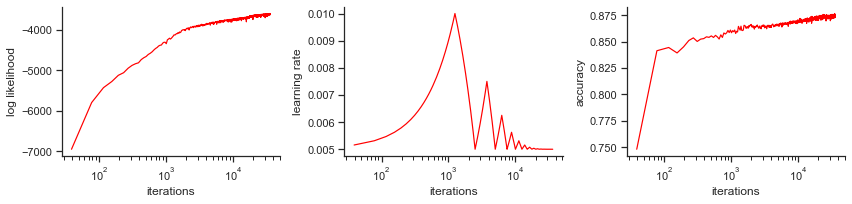

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 1.2})
log = model.tracker.get_data()
fig, axs = plt.subplots(1, 3, figsize=(12, 3), squeeze=False)
g1 = sns.lineplot(ax=axs[0, 0], data=log, x=log.index, y="full_ll", color='red') 
g2 = sns.lineplot(ax=axs[0, 1], data=log, x=log.index, y="lr", color='red')
g3 = sns.lineplot(ax=axs[0, 2],data=log, x=log.index, y="score", color='red') # y = score or full_ll or lr
g1.set(xscale="log", xlabel="iterations", ylabel="log likelihood")
g2.set(xscale="log", xlabel="iterations", ylabel="learning rate")
g3.set(xscale="log", xlabel="iterations", ylabel="accuracy")
sns.despine()
plt.tight_layout()
plt.show()